# Regression

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# Get utils.py

from os.path import basename, exists
import matplotlib.pyplot as plt

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we saw several examples of logistic regression, which is based on the assumption that the likelihood of an outcome, expressed in the form of log odds, is a linear function of some quantity (continuous or discrete).

In this chapter we'll work on examples of simple linear regression, which models the relationship between two quantities.  Specifically, we'll look at changes over time in snowfall and the marathon world record.

The models we'll use have three parameters, so you might want to review the tools we used for the three-parameter model in <<_MarkandRecapture>>.

## More Snow?

I am under the impression that we don't get as much snow around here as we used to.  By "around here" I mean Norfolk County, Massachusetts, where I was born, grew up, and currently live.  And by "used to" I mean compared to when I was young, like in 1978 when we got [27 inches of snow](https://en.wikipedia.org/wiki/Northeastern_United_States_blizzard_of_1978) and I didn't have to go to school for a couple of weeks.

Fortunately, we can test my conjecture with data.  Norfolk County happens to be the location of the [Blue Hill Meteorological Observatory](https://en.wikipedia.org/wiki/Blue_Hill_Meteorological_Observatory), which keeps the oldest continuous weather record in North America.

Data from this and many other weather stations is available from the [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/search) (NOAA).  I collected data from the Blue Hill Observatory from May 11, 1967 to May 11, 2020.  

The following cell downloads the data as a CSV file.

In [4]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv')

We can use Pandas to read the data into `DataFrame`:

In [5]:
import pandas as pd

df = pd.read_csv('2239075.csv', parse_dates=[2])

Here's what the last few rows look like.

In [6]:
df.tail(3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
19357,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57,34.0,34.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19358,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.00,0.0,0.0,44,31.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.00,0.0,0.0,59,38.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['DATE']

0       1967-05-11
1       1967-05-12
2       1967-05-13
3       1967-05-14
4       1967-05-15
           ...    
19355   2020-05-07
19356   2020-05-08
19357   2020-05-09
19358   2020-05-10
19359   2020-05-11
Name: DATE, Length: 19360, dtype: datetime64[ns]

In [8]:
all(pd.date_range(df['DATE'].min(), df['DATE'].max()) == df.DATE)

True

The columns we'll use are:

* `DATE`, which is the date of each observation,

* `SNOW`, which is the total snowfall in inches.

I'll add a column that contains just the year part of the dates.

In [9]:
df['YEAR'] = df['DATE'].dt.year

And use `groupby` to add up the total snowfall in each year.

In [10]:
snow = df.groupby('YEAR')['SNOW'].sum()

The first and last years are not complete, so I'll drop them.

In [11]:
snow = snow.iloc[1:-1]
len(snow)

52

The following figure shows total snowfall during each of the complete years in my lifetime.

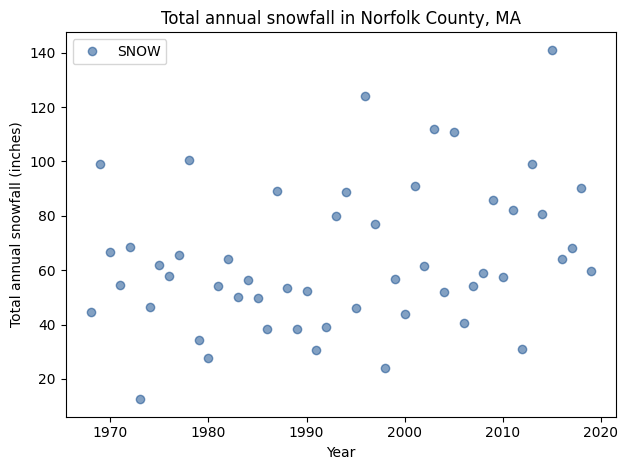

In [12]:
from utils import decorate

snow.plot(ls='', marker='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Total annual snowfall (inches)',
         title='Total annual snowfall in Norfolk County, MA')

Looking at this plot, it's hard to say whether snowfall is increasing, decreasing, or unchanged.  In the last decade, we've had several years with more snow than 1978, including 2015, which was the snowiest winter in the Boston area in modern history, with a total of 141 inches.

This kind of question -- looking at noisy data and wondering whether it is going up or down -- is precisely the question we can answer with Bayesian regression.

In [13]:
snow.loc[[1978, 1996, 2015]]

YEAR
1978    100.6
1996    124.2
2015    141.1
Name: SNOW, dtype: float64

## Regression Model

The foundation of regression (Bayesian or not) is the assumption that a time series like this is the sum of two parts:

1. A linear function of time, and

2. A series of random values drawn from a distribution that is not changing over time.

Mathematically, the regression model is

$$y = a x + b + \epsilon$$

where $y$ is the series of measurements (snowfall in this example), $x$ is the series of times (years) and $\epsilon$ is the series of random values.

$a$ and $b$ are the slope and intercept of the line through the data.  They are unknown parameters, so we will use the data to estimate them.

We don't know the distribution of $\epsilon$, so we'll make the additional assumption that it is a normal distribution with mean 0 and unknown standard deviation, $\sigma$.  
To see whether this assumption is reasonable, I'll plot the distribution of total snowfall and a normal model with the same mean and standard deviation.

Here's a `Pmf` object that represents the distribution of snowfall.

In [14]:
from empiricaldist import Pmf

pmf_snowfall = Pmf.from_seq(snow)

And here are the mean and standard deviation of the data.

In [15]:
mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(64.19038461538462, 26.28802198439569)

I'll use the `norm` object from SciPy to compute the CDF of a normal distribution with the same mean and standard deviation.

In [16]:
from scipy.stats import norm

dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

Here's what the distribution of the data looks like compared to the normal model.

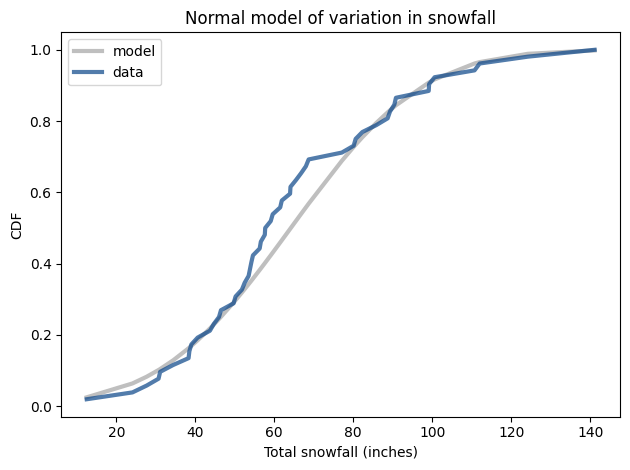

In [17]:
import matplotlib.pyplot as plt

plt.plot(qs, ps, color='C5', label='model')
pmf_snowfall.make_cdf().plot(label='data')

decorate(xlabel='Total snowfall (inches)',
         ylabel='CDF',
         title='Normal model of variation in snowfall')

We've had more winters below the mean than expected, but overall this looks like a reasonable model.

## Least Squares Regression

Our regression model has three parameters: slope, intercept, and standard deviation of $\epsilon$.
Before we can estimate them, we have to choose priors.
To help with that, I'll use StatsModel to fit a line to the data by [least squares regression](https://en.wikipedia.org/wiki/Least_squares).

First, I'll use `reset_index` to convert `snow`, which is a `Series`, to a `DataFrame`.

In [18]:
data = snow.reset_index()
data.head(3)

,YEAR,SNOW
0,1968,44.7
1,1969,99.2
2,1970,66.8


The result is a `DataFrame` with two columns, `YEAR` and `SNOW`, in a format we can use with StatsModels.

As we did in the previous chapter, I'll center the data by subtracting off the mean.

In [19]:
offset = round(data['YEAR'].mean())
data['x'] = data['YEAR'] - offset
offset

1994

And I'll add a column to `data` so the dependent variable has a standard name.

In [20]:
data['y'] = data['SNOW']

Now, we can use StatsModels to compute the least squares fit to the data and estimate `slope` and `intercept`.

In [21]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    64.446325
x             0.511880
dtype: float64

The intercept, about 64 inches, is the expected snowfall when `x=0`, which is the beginning of 1994.
The estimated slope indicates that total snowfall is increasing at a rate of about 0.5 inches per year.  

`results` also provides `resid`, which is an array of residuals, that is, the differences between the data and the fitted line.
The standard deviation of the residuals is an estimate of `sigma`.

In [22]:
results.resid.std() # sigma estimateå

25.385680731210623

We'll use these estimates to choose prior distributions for the parameters.

## Priors

I'll use uniform distributions for all three parameters.

In [23]:
import numpy as np
from utils import make_uniform

qs = np.linspace(-0.5, 1.5, 51)
prior_slope = make_uniform(qs, 'Slope')

In [24]:
qs = np.linspace(54, 75, 41)
prior_inter = make_uniform(qs, 'Intercept')

In [25]:
qs = np.linspace(20, 35, 31)
prior_sigma = make_uniform(qs, 'Sigma')

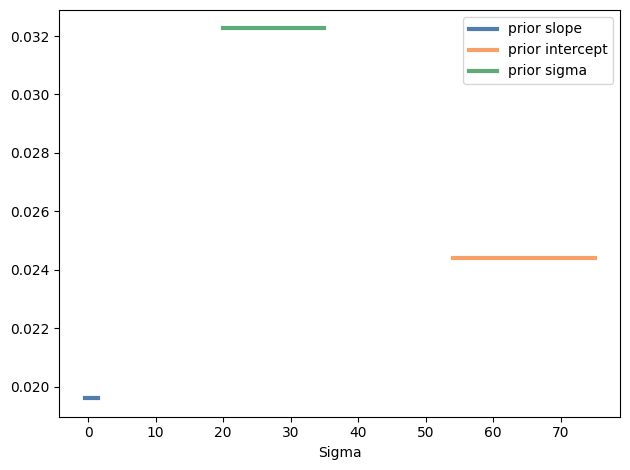

In [26]:
prior_slope.plot(label='prior slope')
prior_inter.plot(label='prior intercept')
prior_sigma.plot(label='prior sigma')
decorate() # uniform distr. for slope, intercept and sigma

I made the prior distributions different lengths for two reasons.  First, if we make a mistake and use the wrong distribution, it will be easier to catch the error if they are all different lengths.

Second, it provides more precision for the most important parameter, `slope`, and spends less computational effort on the least important, `sigma`.

In <<_ThreeParameterModel>> we made a joint distribution with three parameters.  I'll wrap that process in a function:

In [27]:
from utils import make_joint
joint_slope_inter = make_joint(prior_slope, prior_inter)
joint_slope_inter.head() # has slope values as columns and intercept as rows 
joint_slope_inter.stack().head() # creates multi index from putting columns (slope) into the index

Intercept  Slope
54.0       -0.50    0.000478
           -0.46    0.000478
           -0.42    0.000478
           -0.38    0.000478
           -0.34    0.000478
dtype: float64

In [28]:
joint_all_df = make_joint(prior_sigma, joint_slope_inter.stack()) # adds sigma as a column
joint_all = Pmf(joint_all_df.stack())

In [29]:
joint_all

Intercept  Slope  Sigma
54.0       -0.5   20.0     0.000015
                  20.5     0.000015
                  21.0     0.000015
                  21.5     0.000015
                  22.0     0.000015
                             ...   
75.0        1.5   33.0     0.000015
                  33.5     0.000015
                  34.0     0.000015
                  34.5     0.000015
                  35.0     0.000015
Name: , Length: 64821, dtype: float64

In [30]:
from utils import make_joint

def make_joint3(pmf1, pmf2, pmf3):
    """Make a joint distribution with three parameters."""
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

And use it to make a `Pmf` that represents the joint distribution of the three parameters.

In [31]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior.head(3)

Slope  Intercept  Sigma
-0.5   54.0       20.0     0.000015
                  20.5     0.000015
                  21.0     0.000015
Name: , dtype: float64

The index of `Pmf` has three columns, containing values of `slope`, `inter`, and `sigma`, in that order.

With three parameters, the size of the joint distribution starts to get big.  Specifically, it is the product of the lengths of the prior distributions.  In this example, the prior distributions have 51, 41, and 31 values, so the length of the joint prior is 64,821.

In [32]:
len(prior_slope), len(prior_inter), len(prior_sigma)

(51, 41, 31)

In [33]:
len(prior_slope) * len(prior_inter) * len(prior_sigma)

64821

In [34]:
len(prior)

64821

## Likelihood

Now we'll compute the likelihood of the data.
To demonstrate the process, let's assume temporarily that the parameters are known.

In [35]:
inter = 64
slope = 0.51
sigma = 25

I'll extract the `xs` and `ys` from `data` as `Series` objects:

In [36]:
xs = data['x']
ys = data['y']

In [37]:
ys.head() # snow sum values

0    44.7
1    99.2
2    66.8
3    54.6
4    68.7
Name: y, dtype: float64

In [38]:
xs.head() # years centered around mean 

0   -26
1   -25
2   -24
3   -23
4   -22
Name: x, dtype: int32

And compute the "residuals", which are the differences between the actual values, `ys`, and the values we expect based on `slope` and `inter`.

In [39]:
expected = slope * xs + inter
expected.head()

resid = ys - expected

In [40]:
sigma # according to theory, the residuals should follow N(0, sigma)

25

In [41]:
from scipy.stats import norm

norm(0, sigma).pdf(resid).prod()

1.3551948769060997e-105

According to the model, the residuals should follow a normal distribution with mean 0 and standard deviation `sigma`.  So we can compute the likelihood of each residual value using `norm` from SciPy.

In [42]:
densities = norm(0, sigma).pdf(resid)

The result is an array of probability densities, one for each element of the dataset; their product is the likelihood of the data.

In [43]:
likelihood = densities.prod()
likelihood

1.3551948769060997e-105

In [44]:
log_likelihood = np.log(densities).sum()
log_likelihood

-241.4674894997894

As we saw in the previous chapter, the likelihood of any particular dataset tends to be small.
If it's too small, we might exceed the limits of floating-point arithmetic.
When that happens, we can avoid the problem by computing likelihoods under a log transform.
But in this example that's not necessary.

## The Update

Now we're ready to do the update.  First, we need to compute the likelihood of the data for each possible set of parameters.

In [45]:
likelihood = prior.copy()

for slope, intercept, sigma in prior.index:
    snow_expected = slope * xs + intercept
    resid = ys - snow_expected
    densities = norm(0, sigma).pdf(resid)
    likelihood[slope, intercept, sigma] = densities.prod()
    # likelihood[slope, intercept, sigma] = densities.prod()

In [46]:
posterior = prior * likelihood
posterior.normalize()

6.769832641515688e-107

In [47]:
slope_posterior = posterior.marginal(0)
inter_posterior = posterior.marginal(1)
sigma_posterior = posterior.marginal(2)

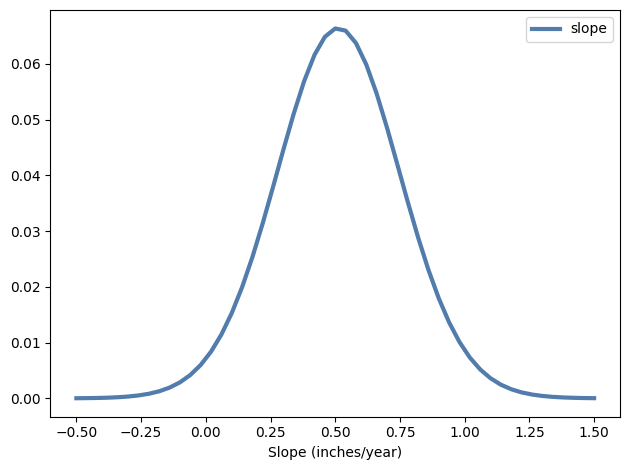

In [48]:
slope_posterior.plot(label='slope')
decorate(xlabel='Slope (inches/year)')

In [49]:
likelihood = prior.copy()

for slope, inter, sigma in prior.index:
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm.pdf(resid, 0, sigma)
    likelihood[slope, inter, sigma] = densities.prod()

This computation takes longer than many of the previous examples.
We are approaching the limit of what we can do with grid approximations.

Nevertheless, we can do the update in the usual way:

In [50]:
posterior = prior * likelihood
posterior.normalize()

6.769832641515688e-107

The result is a `Pmf` with a three-level index containing values of `slope`, `inter`, and `sigma`.
To get the marginal distributions from the joint posterior, we can use `Pmf.marginal`, which we saw in <<_ThreeParameterModel>>.

In [51]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

Here's the posterior distribution for `sigma`:

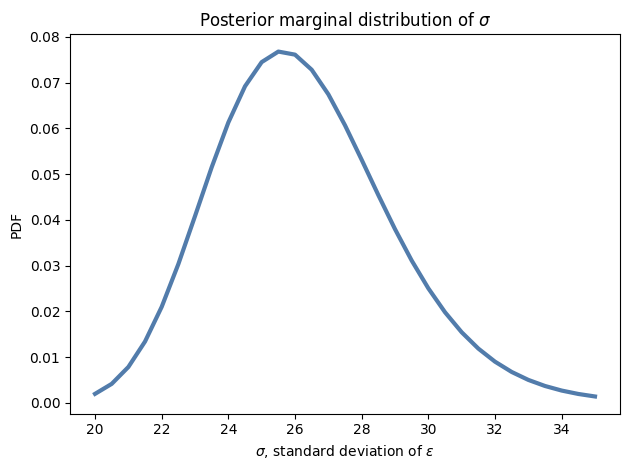

In [52]:
posterior_sigma.plot()

decorate(xlabel='$\sigma$, standard deviation of $\epsilon$',
         ylabel='PDF',
         title='Posterior marginal distribution of $\sigma$')

The most likely values for `sigma` are near 26 inches, which is consistent with our estimate based on the standard deviation of the data.

However, to say whether snowfall is increasing or decreasing, we don't really care about `sigma`.  It is a "nuisance parameter", so-called because we have to estimate it as part of the model, but we don't need it to answer the questions we are interested in.

Nevertheless, it is good to check the marginal distributions to make sure 

* The location is consistent with our expectations, and 

* The posterior probabilities are near 0 at the extremes of the range, which indicates that the prior distribution covers all parameters with non-negligible probability.

In this example, the posterior distribution of `sigma` looks fine.

Here's the posterior distribution of `inter`:

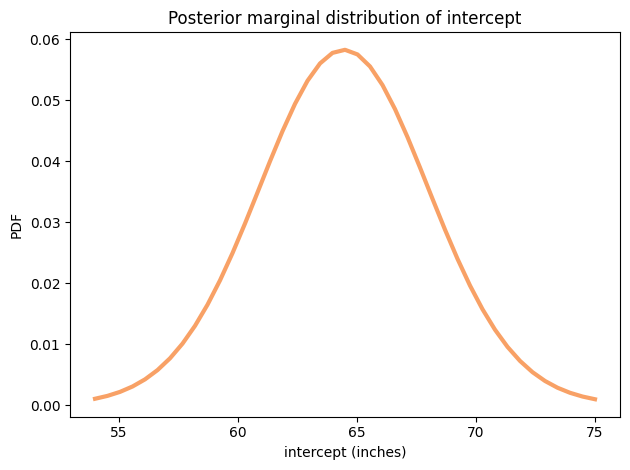

In [53]:
posterior_inter.plot(color='C1')
decorate(xlabel='intercept (inches)',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [54]:
from utils import summarize
    
summarize(posterior_inter) 

64.448 [58.725 70.275]


The posterior mean is about 64 inches, which is the expected amount of snow during the year at the midpoint of the range, 1994.

And finally, here's the posterior distribution of `slope`:

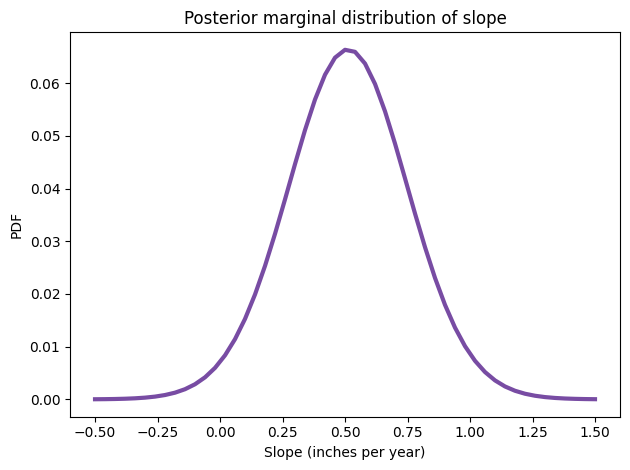

In [55]:
posterior_slope.plot(color='C4')
decorate(xlabel='Slope (inches per year)',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [56]:
summarize(posterior_slope)

0.512 [0.1 0.9]


The posterior mean is about 0.51 inches, which is consistent with the estimate we got from least squared regression.  

The 90% credible interval is from 0.1 to 0.9, which indicates that our uncertainty about this estimate is pretty high.  In fact, there is still a small posterior probability (about 2\%) that the slope is negative. 

In [57]:
posterior_slope.make_cdf()(0)

array(0.01840519)

However, it is more likely that my conjecture was wrong: we are actually getting more snow around here than we used to, increasing at a rate of about a half-inch per year, which is substantial.  On average, we get an additional 25 inches of snow per year than we did when I was young.

This example shows that with slow-moving trends and noisy data, your instincts can be misleading.  

Now, you might suspect that I overestimate the amount of snow when I was young because I enjoyed it, and underestimate it now because I don't.  But you would be mistaken.

During the Blizzard of 1978, we did not have a snowblower and my brother and I had to shovel.  My sister got a pass for no good reason.  Our driveway was about 60 feet long and three cars wide near the garage.  And we had to shovel Mr. Crocker's driveway, too, for which we were not allowed to accept payment.  Furthermore, as I recall it was during this excavation that I accidentally hit my brother with a shovel on the head, and it bled a lot because, you know, scalp wounds.

Anyway, the point is that I don't think I overestimate the amount of snow when I was young because I have fond memories of it. 

## Optimization

The way we computed the likelihood in the previous section was pretty slow.  The problem is that we looped through every possible set of parameters in the prior distribution, and there were more than 60,000 of them.

If we can do more work per iteration, and run the loop fewer times, we expect it to go faster.

In order to do that, I'll unstack the prior distribution:

In [58]:
help(pd.DataFrame().unstack())

Help on Series in module pandas.core.series object:

class Series(pandas.core.base.IndexOpsMixin, pandas.core.generic.NDFrame)
 |  Series(data=None, index=None, dtype: 'Dtype | None' = None, name=None, copy: 'bool | None' = None, fastpath: 'bool' = False) -> 'None'
 |  
 |  One-dimensional ndarray with axis labels (including time series).
 |  
 |  Labels need not be unique but must be a hashable type. The object
 |  supports both integer- and label-based indexing and provides a host of
 |  methods for performing operations involving the index. Statistical
 |  methods from ndarray have been overridden to automatically exclude
 |  missing data (currently represented as NaN).
 |  
 |  Operations between Series (+, -, /, \*, \*\*) align values based on their
 |  associated index values-- they need not be the same length. The result
 |  index will be the sorted union of the two indexes.
 |  
 |  Parameters
 |  ----------
 |  data : array-like, Iterable, dict, or scalar value
 |      Contain

In [59]:
prior # multi index 

Slope  Intercept  Sigma
-0.5   54.0       20.0     0.000015
                  20.5     0.000015
                  21.0     0.000015
                  21.5     0.000015
                  22.0     0.000015
                             ...   
 1.5   75.0       33.0     0.000015
                  33.5     0.000015
                  34.0     0.000015
                  34.5     0.000015
                  35.0     0.000015
Name: , Length: 64821, dtype: float64

In [60]:
prior.unstack() # unstack puts innermost level as columns

Sigma                20.0      20.5      21.0      21.5      22.0      22.5  \
Slope Intercept                                                               
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.575     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      56.100     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
...                   ...       ...       ...       ...       ...       ...   
 1.5  72.900     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      73.425     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      73.950     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      74.475     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      75.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   

Sigma                23.0      23.5      24.0      24.5  ...      30.5  \
Slope Intercept                                          ...             
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      55.575     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      56.100     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
...                   ...       ...       ...       ...  ...       ...   
 1.5  72.900     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      73.425     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      73.950     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      74.475     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      75.000     0.000015  0.000015  0.000015  0.000015  ...  0.000015   

Sigma                31.0      31.5      32.0      32.5      33.0      33.5  \
Slope Intercept                                                               
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.575     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      56.100     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
...                   ...       ...       ...       ...       ...       ...   
 1.5  72.900     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      73.425     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      73.950     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      74.475     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      75.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   

Sigma                34.0      34.5      35.0  
Slope Intercept                                
-0.5  54.000     0.000015  0.000015  0.000015  
      54.525     0.000015  0.000015  0.000015  
      55.050     0.000015  0.000015  0.000015  
      55.575     0.000015  0.000015  0.000015  
      56.100     0.000015  0.000015  0.000015  
...                   ...       ...       ...  
 1.5  72.900     0.000015  0.000015  0.000015  
      73.425     0.000015  0.000015  0.000015  
      73.950     0.000015  0.000015  0.000015  
      74.475     0.000015  0.000015  0.000015  
      75.000     0.000015  0.000015  0.000015  

[2091 rows x 31 columns]

In [61]:
joint3 = prior.unstack()
joint3.head(3)

Sigma                20.0      20.5      21.0      21.5      22.0      22.5  \
Slope Intercept                                                               
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   

Sigma                23.0      23.5      24.0      24.5  ...      30.5  \
Slope Intercept                                          ...             
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  ...  0.000015   

Sigma                31.0      31.5      32.0      32.5      33.0      33.5  \
Slope Intercept                                                               
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   

Sigma                34.0      34.5      35.0  
Slope Intercept                                
-0.5  54.000     0.000015  0.000015  0.000015  
      54.525     0.000015  0.000015  0.000015  
      55.050     0.000015  0.000015  0.000015  

[3 rows x 31 columns]

In [62]:
likelihood = joint3.copy()
sigmas = joint3.columns

for slope, inter in joint3.index:
    print(slope, inter)
    expected = slope * xs + inter
    resid = ys - expected
    sigma_meshgrid, resid_meshgrid = np.meshgrid(sigmas, resid)
    likelihoods = norm(0, sigma_meshgrid).pdf(resid_meshgrid)
    likelihood.loc[slope, inter] = likelihoods.prod(axis=0)

-0.5 54.0
-0.5 54.525
-0.5 55.05
-0.5 55.575
-0.5 56.1
-0.5 56.625
-0.5 57.15
-0.5 57.675
-0.5 58.2
-0.5 58.725
-0.5 59.25
-0.5 59.775
-0.5 60.3
-0.5 60.825
-0.5 61.35
-0.5 61.875
-0.5 62.4
-0.5 62.925
-0.5 63.45
-0.5 63.975
-0.5 64.5
-0.5 65.025
-0.5 65.55
-0.5 66.075
-0.5 66.6
-0.5 67.125
-0.5 67.65
-0.5 68.175
-0.5 68.7
-0.5 69.225
-0.5 69.75
-0.5 70.275
-0.5 70.8
-0.5 71.325
-0.5 71.85
-0.5 72.375
-0.5 72.9
-0.5 73.425
-0.5 73.95
-0.5 74.475
-0.5 75.0
-0.46 54.0
-0.46 54.525
-0.46 55.05
-0.46 55.575
-0.46 56.1
-0.46 56.625
-0.46 57.15
-0.46 57.675
-0.46 58.2
-0.46 58.725
-0.46 59.25
-0.46 59.775
-0.46 60.3
-0.46 60.825
-0.46 61.35
-0.46 61.875
-0.46 62.4
-0.46 62.925
-0.46 63.45
-0.46 63.975
-0.46 64.5
-0.46 65.025
-0.46 65.55
-0.46 66.075
-0.46 66.6
-0.46 67.125
-0.46 67.65
-0.46 68.175
-0.46 68.7
-0.46 69.225
-0.46 69.75
-0.46 70.275
-0.46 70.8
-0.46 71.325
-0.46 71.85
-0.46 72.375
-0.46 72.9
-0.46 73.425
-0.46 73.95
-0.46 74.475
-0.46 75.0
-0.42 54.0
-0.42 54.525
-0.42 55.05
-0.

In [63]:
likelihood.shape, joint3.shape

((2091, 31), (2091, 31))

In [64]:
posterior_opt = joint3 * likelihood

In [65]:
posterior_opt = Pmf(posterior_opt.stack())
posterior_opt.normalize()

6.769832641515688e-107

In [66]:
np.allclose(posterior, posterior_opt)

True

In [67]:
likelihoods.prod(axis = 0).shape

(31,)

In [68]:
resid_meshgrid, sigma_meshgrid = np.meshgrid(resid, sigmas)

In [69]:
sigma_meshgrid.shape, resid_meshgrid.shape

densities = norm(0, sigma_meshgrid).pdf(resid_meshgrid)

In [70]:
densities.shape, sigmas.shape

((31, 52), (31,))

In [71]:
densities.prod(axis = 0).shape

(52,)

In [72]:
likelihood.loc[slope, inter].shape

(31,)

The result is a `DataFrame` with `slope` and `intercept` down the rows and `sigmas` across the columns.

The following is a version of `likelihood_regression` that takes the joint prior distribution in this form and returns the posterior distribution in the same form.

In [73]:
from utils import normalize

def update_optimized(prior, data):
    """Posterior distribution of regression parameters
    `slope`, `inter`, and `sigma`.
    
    prior: Pmf representing the joint prior
    data: DataFrame with columns `x` and `y`
    
    returns: Pmf representing the joint posterior
    """
    xs = data['x']
    ys = data['y']
    sigmas = prior.columns    
    likelihood = prior.copy()

    for slope, inter in prior.index:
        expected = slope * xs + inter
        resid = ys - expected
        resid_mesh, sigma_mesh = np.meshgrid(resid, sigmas)
        densities = norm.pdf(resid_mesh, 0, sigma_mesh)
        likelihood.loc[slope, inter] = densities.prod(axis=1)
        
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

This version loops through all possible pairs of `slope` and `inter`, so the loop runs about 2000 times.

In [74]:
len(prior_slope) * len(prior_inter)

2091

Each time through the loop, it uses a grid mesh to compute the likelihood of the data for all values of `sigma`.  The result is an array with one column for each data point and one row for each value of `sigma`.  Taking the product across the columns (`axis=1`) yields the probability of the data for each value of sigma, which we assign as a row in `likelihood`.

In [75]:
%time posterior_opt = update_optimized(joint3, data)

CPU times: user 601 ms, sys: 10.4 ms, total: 611 ms
Wall time: 611 ms


We get the same result either way.

In [76]:
np.allclose(posterior, posterior_opt.stack())

True

In [77]:
from utils import marginal, plot_contour 

posterior2 = marginal(posterior_opt, 1)
posterior2.head(3)

Slope  Intercept
-0.5   54.000       7.633362e-08
       54.525       1.013295e-07
       55.050       1.327249e-07
Name: , dtype: float64

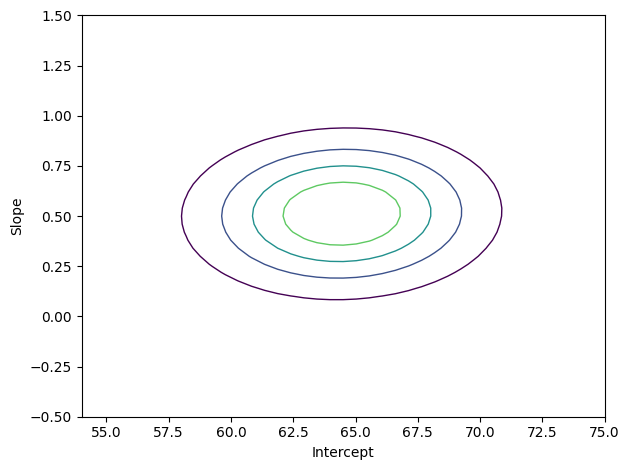

In [78]:
plot_contour(posterior2.unstack())

But this version is about 25 times faster than the previous version.  

This optimization works because many functions in NumPy and SciPy are written in C, so they run fast compared to Python.  If you can do more work each time you call these functions, and less time running the loop in Python, your code will often run substantially faster.

In this version of the posterior distribution, `slope` and `inter` run down the rows and `sigma` runs across the columns.  So we can use `marginal` to get the posterior joint distribution of `slope` and `intercept`.

In [79]:
from utils import marginal

posterior2 = marginal(posterior_opt, 1)
posterior2.head(3)

Slope  Intercept
-0.5   54.000       7.633362e-08
       54.525       1.013295e-07
       55.050       1.327249e-07
Name: , dtype: float64

The result is a `Pmf` with two columns in the index.
To plot it, we have to unstack it.

In [80]:
joint_posterior = posterior2.unstack().transpose()
joint_posterior.head(3)

Slope,-0.50,-0.46,-0.42,-0.38,-0.34,-0.30,-0.26,-0.22,-0.18,-0.14,...,1.14,1.18,1.22,1.26,1.30,1.34,1.38,1.42,1.46,1.50
Intercept,,,,,,,,,,,,,,,,,,,,,
54.000,7.633362e-08,1.244120e-07,1.999617e-07,3.168007e-07,4.945131e-07,7.601557e-07,0.000001,0.000002,0.000003,0.000004,...,0.000003,0.000002,0.000001,9.123148e-07,5.975833e-07,3.853761e-07,2.448104e-07,1.532653e-07,9.460588e-08,5.760046e-08
54.525,1.013295e-07,1.658787e-07,2.678095e-07,4.262364e-07,6.684267e-07,1.032304e-06,0.000002,0.000002,0.000003,0.000005,...,0.000004,0.000003,0.000002,1.272146e-06,8.301525e-07,5.333476e-07,3.375444e-07,2.105422e-07,1.294898e-07,7.856004e-08
55.050,1.327249e-07,2.182169e-07,3.538722e-07,5.657543e-07,8.912797e-07,1.382827e-06,0.000002,0.000003,0.000005,0.000007,...,0.000006,0.000004,0.000003,1.750579e-06,1.138148e-06,7.285261e-07,4.593750e-07,2.854925e-07,1.749592e-07,1.057750e-07


Here's what it looks like.

/Users/matejuhrin/repo/ThinkBayes2/notebooks/utils.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


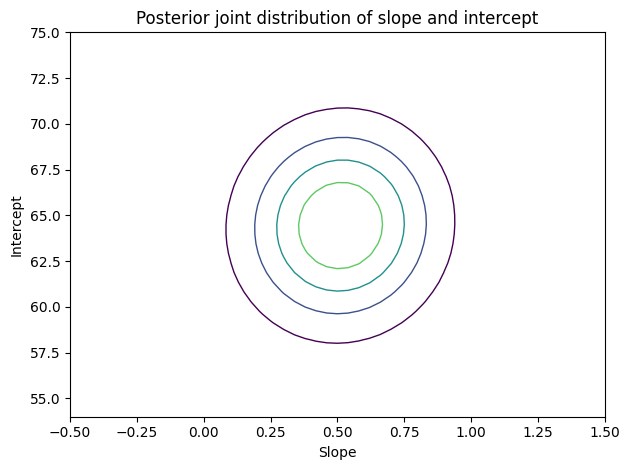

In [81]:
from utils import plot_contour

plot_contour(joint_posterior)
decorate(title='Posterior joint distribution of slope and intercept')

The ovals in the contour plot are aligned with the axes, which indicates that there is no correlation between `slope` and `inter` in the posterior distribution, which is what we expect since we centered the values.

In this example, the motivating question is about the slope of the line, so we answered it by looking at the posterior distribution of slope.

In the next example, the motivating question is about prediction, so we'll use the joint posterior distribution to generate predictive distributions.

## Marathon World Record

For many running events, if you plot the world record pace over time, the result is a remarkably straight line.  People, [including me](http://allendowney.blogspot.com/2011/04/two-hour-marathon-in-2045.html), have speculated about possible reasons for this phenomenon.

People have also speculated about when, if ever, the world record time for the marathon will be less than two hours.
(Note: In 2019 Eliud Kipchoge ran the marathon distance in under two hours, which is an astonishing achievement that I fully appreciate, but for several reasons it did not count as a world record).

So, as a second example of Bayesian regression, we'll consider the world record progression for the marathon (for male runners), estimate the parameters of a linear model, and use the model to predict when a runner will break the two-hour barrier.  

The following cell downloads a web page from Wikipedia that includes a table of marathon world records, and uses Pandas to put the data in a `DataFrame`.

In [82]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

If that doesn't work, I have made a copy of this page available.  The following cell downloads and parses it.

In [83]:
#import os

#datafile = 'Marathon_world_record_progression.html'
#download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/Marathon_world_record_progression.html')

#tables = pd.read_html(datafile)
#len(tables)

The first table is the one we want.

In [84]:
table = tables[0]
table.tail(3)

,Time,Name,Nationality,Date,Event/Place,Source,Notes
48,2:02:57,Dennis Kimetto,Kenya,"September 28, 2014",Berlin Marathon,IAAF[85][86] ARRS[82],The ARRS notes Kimetto's extended time as 2:02...
49,2:01:39,Eliud Kipchoge,Kenya,"September 16, 2018",Berlin Marathon,IAAF[1],NaN
50,2:01:09,Eliud Kipchoge,Kenya,"September 25, 2022",Berlin Marathon,IAAF[87],NaN


In [85]:
table.shape

(51, 7)

We can use Pandas to parse the dates.
A few of them include notes that cause parsing problems, but the argument `errors='coerce'` tells Pandas to fill invalid dates with `NaT`, which is a version of `NaN` that represents "not a time". 

In [86]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

We can also use Pandas to parse the record times.

In [87]:
table['time'] = pd.to_timedelta(table['Time'])

And convert the times to paces in miles per hour.

In [88]:
table['y'] = (26.2 / table['time'].dt.total_seconds()) * 3600 # 26.2 miles in a marathon / time in seconds * 3600 to get miles per hour
table['y'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: y, dtype: float64

The following function plots the results.

In [89]:
def plot_speeds(df):
    """Plot marathon world record speed as a function of time.
    
    df: DataFrame with date and mph
    """
    plt.axhline(13.1, color='C5', ls='--')
    plt.plot(df['date'], df['y'], 'o', 
             label='World record speed', 
             color='C1', alpha=0.5)
    
    decorate(xlabel='Date',
             ylabel='Speed (mph)')

Here's what the results look like.
The dashed line shows the speed required for a two-hour marathon, 13.1 miles per hour.

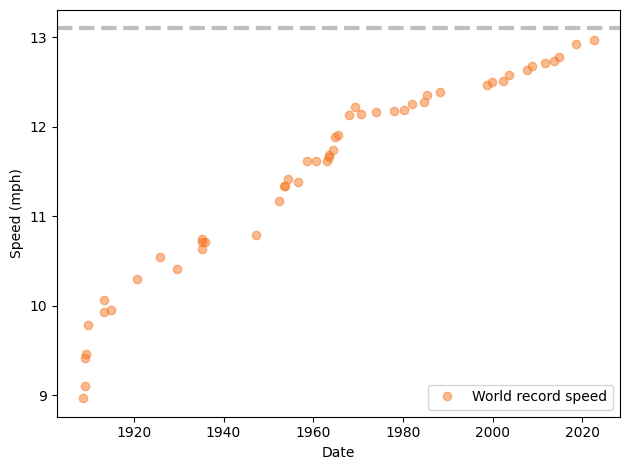

In [90]:
plot_speeds(table)

It's not a perfectly straight line.  In the early years of the marathon, the record speed increased quickly; since about 1970, it has been increasing more slowly.

For our analysis, let's focus on the recent progression, starting in 1970.

In [91]:
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh, Scotland",ARRS[9],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch, New Zealand",ARRS[9],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[9],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[9],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[9]",NaN,1981-12-06,0 days 02:08:18,12.252533


In the notebook for this chapter, you can see how I loaded and cleaned the data.  The result is a `DataFrame` that contains the following columns (and additional information we won't use):

* `date`, which is a Pandas `Timestamp` representing the date when the world record was broken, and

* `speed`, which records the record-breaking pace in mph.

Here's what the results look like, starting in 1970:

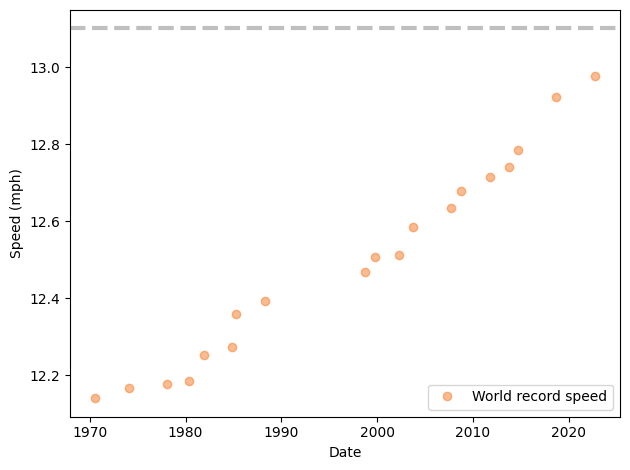

In [92]:
plot_speeds(data)

The data points fall approximately on a line, although it's possible that the slope is increasing.

To prepare the data for regression, I'll subtract away the approximate midpoint of the time interval, 1995.

In [93]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset

In [94]:
timedelta.dt.total_seconds() / 3600 /24 / 365.24
# to secs / to hours/ to days / toyrs

0    -86.441792
1    -86.000986
2    -85.885993
3    -85.653269
4           NaN
5    -85.338408
6    -81.642208
7    -81.590187
8    -80.092542
9    -74.362063
10   -69.222977
11   -65.493922
12   -59.785347
13   -59.757967
14   -59.749754
15   -59.163837
16   -47.705618
17   -42.550104
18   -41.553499
19   -41.244113
20   -40.518563
21   -38.388457
22   -36.356916
23   -34.308948
24   -31.872194
25   -31.549118
26   -31.491622
27   -30.552513
28   -30.196583
29   -29.555908
30   -27.080824
31   -25.591392
32   -24.444201
33   -20.917753
34   -16.903954
35   -14.683496
36   -13.070858
37   -10.196035
38    -9.700471
39    -6.707918
40     3.718103
41     4.810536
42     7.282882
43     8.739459
44    12.745044
45    13.741649
46    16.731464
47    18.743840
48    19.740445
49    23.707699
50    27.732450
Name: date, dtype: float64

When we subtract two `Timestamp` objects, the result is a "time delta", which we can convert to seconds and then to years.

In [95]:
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24

# 365.24 average length of a year in gregorian calendar every four years we have 366 days

In [96]:
data[['x','y']].describe() # data y is in mph maraton speed, x is in years

,x,y
count,19.000000,19.000000
mean,2.161520,12.498474
std,16.212660,0.262033
min,-24.444201,12.140871
25%,-11.633447,12.262896
50%,4.810536,12.505967
75%,15.236557,12.697071
max,27.732450,12.975650


In [97]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params # intercept and slope (denoted x)

Intercept    12.464040
x             0.015931
dtype: float64

In [98]:
results.resid.std() # prior of sigma around this val 

0.04419653543387603

In [99]:
qs = np.linspace(0.009, 0.025, 51)
prior_slope = make_uniform(qs, 'Slope')

qs = np.linspace(10.5, 13.5, 41)
prior_inter = make_uniform(qs, 'Intercept')

qs = np.linspace(0.01, 0.03, 31)
prior_sigma = make_uniform(qs, 'Sigma')

prior_slope.shape, prior_inter.shape, prior_sigma.shape

((51,), (41,), (31,))

In [100]:
joint3 = make_joint3(prior_slope, prior_inter, prior_sigma)

In [101]:
xs, ys = data['x'], data['y']

In [102]:
prior = joint3.unstack().copy()

In [103]:
posterior = update_optimized(prior, data)

In [104]:
posterior2 = marginal(posterior, 1).unstack()

In [105]:
posterior_slope = marginal(posterior2, 1)
posterior_inter = marginal(posterior2, 0)

summarize(posterior_slope) # world record speed increases by about 0,016 mph per year

0.016 [0.0154  0.01668]


In [106]:
data.tail()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y,x
46,2:03:38,Patrick Makau,Kenya,"September 25, 2011",Berlin Marathon,"IAAF,[80][81] ARRS[82]",NaN,2011-09-25,0 days 02:03:38,12.715018,16.731464
47,2:03:23,Wilson Kipsang,Kenya,"September 29, 2013",Berlin Marathon,IAAF[83][84] ARRS[82],The ARRS notes Kipsang's extended time as 2:03...,2013-09-29,0 days 02:03:23,12.740781,18.743840
48,2:02:57,Dennis Kimetto,Kenya,"September 28, 2014",Berlin Marathon,IAAF[85][86] ARRS[82],The ARRS notes Kimetto's extended time as 2:02...,2014-09-28,0 days 02:02:57,12.785685,19.740445
49,2:01:39,Eliud Kipchoge,Kenya,"September 16, 2018",Berlin Marathon,IAAF[1],NaN,2018-09-16,0 days 02:01:39,12.922318,23.707699
50,2:01:09,Eliud Kipchoge,Kenya,"September 25, 2022",Berlin Marathon,IAAF[87],NaN,2022-09-25,0 days 02:01:09,12.975650,27.732450


In [107]:
summarize(posterior_inter)
# mean with 90% CI

12.45 [12.45 12.45]


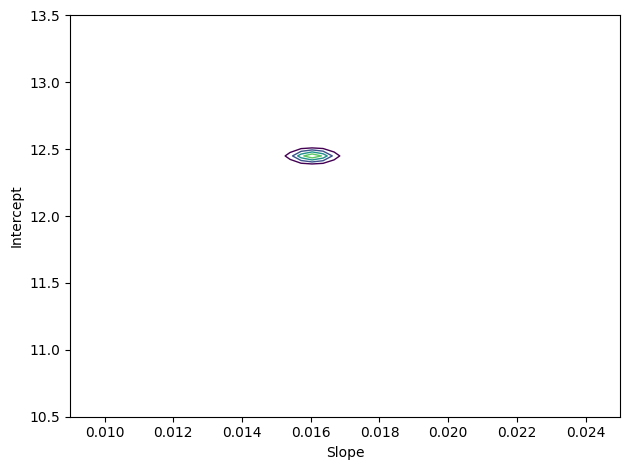

In [108]:
plot_contour(posterior2.T)

In [109]:
posterior_pmf = Pmf(posterior.stack())

In [110]:
posterior_pmf

Slope  Intercept  Sigma   
0.009  10.5       0.010000    0.0
                  0.010667    0.0
                  0.011333    0.0
                  0.012000    0.0
                  0.012667    0.0
                             ... 
0.025  13.5       0.027333    0.0
                  0.028000    0.0
                  0.028667    0.0
                  0.029333    0.0
                  0.030000    0.0
Name: , Length: 64821, dtype: float64

As in the previous example, I'll use least squares regression to compute point estimates for the parameters, which will help with choosing priors.

The estimated intercept is about 12.5 mph, which is the interpolated world record pace for 1995.  The estimated slope is about 0.015 mph per year, which is the rate the world record pace is increasing, according to the model.

Again, we can use the standard deviation of the residuals as a point estimate for `sigma`.

In [111]:
results.resid.std()

0.04419653543387603

These parameters give us a good idea where we should put the prior distributions.

## The Priors

Here are the prior distributions I chose for `slope`, `intercept`, and `sigma`.

In [112]:
qs = np.linspace(0.012, 0.018, 51)
prior_slope = make_uniform(qs, 'Slope')

In [113]:
qs = np.linspace(12.4, 12.5, 41)
prior_inter = make_uniform(qs, 'Intercept')

In [114]:
qs = np.linspace(0.01, 0.21, 31)
prior_sigma = make_uniform(qs, 'Sigma')

And here's the joint prior distribution.

In [115]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior.head()

Slope  Intercept  Sigma   
0.012  12.4       0.010000    0.000015
                  0.016667    0.000015
                  0.023333    0.000015
Name: , dtype: float64

Now we can compute likelihoods as in the previous example:

In [116]:
xs = data['x']
ys = data['y']
likelihood = prior.copy()

for slope, inter, sigma in prior.index:
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm.pdf(resid, 0, sigma)
    likelihood[slope, inter, sigma] = densities.prod()

Now we can do the update in the usual way.

In [117]:
posterior = prior * likelihood
posterior.normalize()

1161389020604.0317

And unpack the marginals:

In [118]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

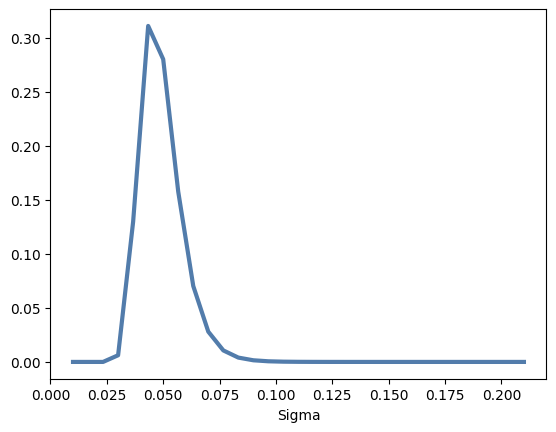

In [119]:
posterior_sigma.plot();

Here's the posterior distribution of `inter`:

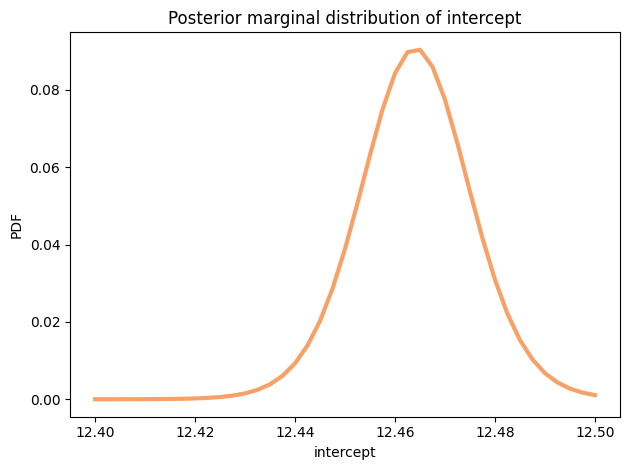

In [120]:
posterior_inter.plot(color='C1')
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [121]:
summarize(posterior_inter)

12.464 [12.445  12.4825]


The posterior mean is about 12.5 mph, which is the world record marathon pace the model predicts for the midpoint of the date range, 1994.

And here's the posterior distribution of `slope`.

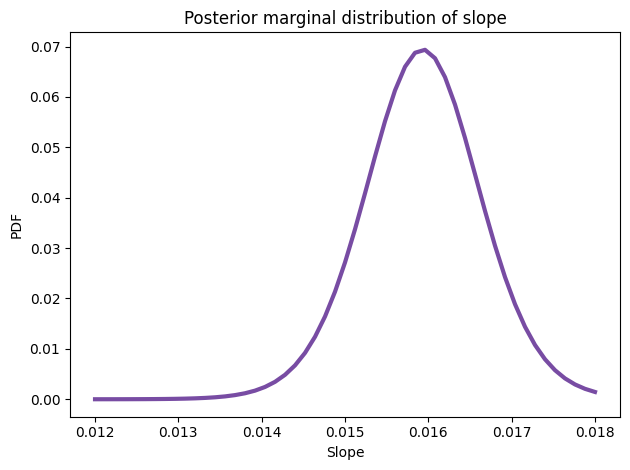

In [122]:
posterior_slope.plot(color='C4')
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [123]:
summarize(posterior_slope)

0.016 [0.01476 0.01704]


The posterior mean is about 0.015 mph per year, or 0.15 mph per decade.

That's interesting, but it doesn't answer the question we're interested in: When will there be a two-hour marathon? To answer that, we have to make predictions.

## Prediction

To generate predictions, I'll draw a sample from the posterior distribution of parameters, then use the regression equation to combine the parameters with the data.

`Pmf` provides `choice`, which we can use to draw a random sample with replacement, using the posterior probabilities as weights.

In [124]:
np.random.seed(17)

In [125]:
sample = posterior.choice(101)
xs = np.arange(-30, 50, 2)

In [126]:
pred = np.empty((len(sample), len(xs)))

In [127]:
for i, (slope, inter, sigma) in enumerate(sample):
    epsilon = norm(0, sigma).rvs(len(xs)) # generate ~ N(0, sigma) len(xs) random values
    ys = slope * xs + inter + epsilon
    pred[i,:] = ys

In [128]:
low, median, high = np.percentile(pred, [5, 50, 95], axis = 0)

In [129]:
low

array([11.89161149, 11.94369416, 11.97555457, 12.00748345, 12.03302876,
       12.0627251 , 12.07106449, 12.12565306, 12.16468474, 12.19515354,
       12.21458343, 12.26542027, 12.27429444, 12.33440241, 12.32838509,
       12.37426603, 12.41336362, 12.45015365, 12.47451041, 12.5211133 ,
       12.54843773, 12.57771589, 12.62093929, 12.6460279 , 12.66954797,
       12.69119199, 12.74007711, 12.76578662, 12.79323649, 12.8128788 ,
       12.84721792, 12.90290494, 12.90466159, 12.94839385, 12.98070944,
       13.00631137, 13.04041325, 13.06221798, 13.09805374, 13.1410795 ])

In [130]:
high

array([12.09974387, 12.12304451, 12.13307325, 12.19500264, 12.20149997,
       12.24527844, 12.28382794, 12.3054624 , 12.34506215, 12.35564893,
       12.38924331, 12.42930683, 12.43733296, 12.48230839, 12.50612625,
       12.5272677 , 12.58881109, 12.61231596, 12.64348943, 12.68342427,
       12.69326756, 12.73878486, 12.77000775, 12.80262722, 12.8299865 ,
       12.8876288 , 12.89525351, 12.91539237, 12.94492045, 12.99670752,
       13.03743467, 13.06436119, 13.09684227, 13.14044646, 13.12619498,
       13.22334896, 13.19414207, 13.23595324, 13.28679243, 13.32879814])

In [131]:
offset

Timestamp('1995-01-01 00:00:00')

In [132]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset
times

DatetimeIndex(['1964-12-31 19:11:59.999999940',
               '1967-01-01 06:43:11.999999897',
               '1968-12-31 18:14:24.000000018',
               '1971-01-01 05:45:35.999999983',
               '1972-12-31 17:16:47.999999940',
               '1975-01-01 04:47:59.999999983',
               '1976-12-31 16:19:12.000000026',
               '1979-01-01 03:50:23.999999992',
               '1980-12-31 15:21:35.999999949',
               '1983-01-01 02:52:47.999999992',
               '1984-12-31 14:23:59.999999992',
               '1987-01-01 01:55:11.999999992',
               '1988-12-31 13:26:23.999999992',
                         '1991-01-01 00:57:36',
                         '1992-12-31 12:28:48',
                         '1995-01-01 00:00:00',
                         '1996-12-31 11:31:12',
                         '1998-12-31 23:02:24',
               '2000-12-31 10:33:36.000000008',
               '2002-12-31 22:04:48.000000008',
               '2004-12-31 09:36:00.0000

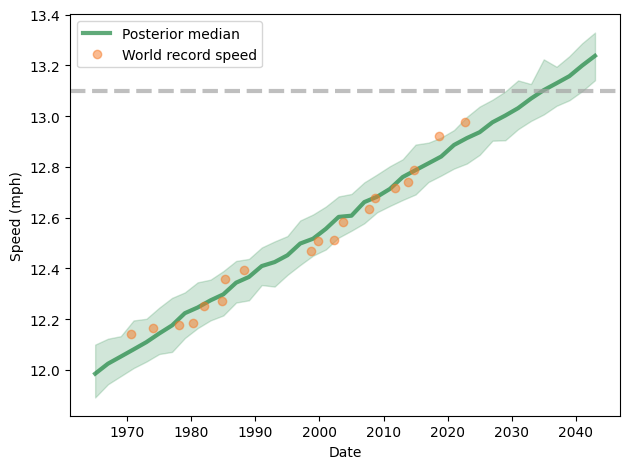

In [133]:
plt.fill_between(times, low, high, color='C2', alpha=0.2)
plt.plot(times, median, color='C2', label='Posterior median')
plot_speeds(data)

In [134]:
median

array([11.98530213, 12.02466118, 12.05268183, 12.08096147, 12.10963822,
       12.14368431, 12.17545763, 12.22358928, 12.24599336, 12.27413903,
       12.29772157, 12.34383077, 12.36635658, 12.40926544, 12.42485891,
       12.4516258 , 12.49794152, 12.51685531, 12.55580597, 12.60289036,
       12.6076151 , 12.66120592, 12.68230051, 12.71310643, 12.75992801,
       12.78702797, 12.81373501, 12.84063027, 12.8861076 , 12.91319764,
       12.93650648, 12.97548846, 13.00202192, 13.03120827, 13.06872607,
       13.10216575, 13.12936454, 13.15720524, 13.19894922, 13.23729114])

In [135]:
from scipy.interpolate import interp1d

future = np.array([
    interp1d(low,xs)(13.1),
    interp1d(median, xs)(13.1),
    interp1d(high, xs)(13.1)
          ])

In [136]:
dts = pd.to_timedelta(future * 365.24, unit="days") + offset

df = pd.DataFrame({'datetime':dts}, index = ['high', 'median', 'low'])
df

,datetime
high,2041-02-02 01:59:44.170897709
median,2034-11-14 06:57:17.734911523
low,2029-06-06 07:52:43.635143743


The result is an array of tuples.  Looping through the sample, we can use the regression equation to generate predictions for a range of `xs`.

In [137]:
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter, sigma) in enumerate(sample):
    epsilon = norm(0, sigma).rvs(len(xs))
    pred[i] = inter + slope * xs + epsilon

Each prediction is an array with the same length as `xs`, which I store as a row in `pred`.  So the result has one row for each sample and one column for each value of `x`.

We can use `percentile` to compute the 5th, 50th, and 95th percentiles in each column.

In [138]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

To show the results, I'll plot the median of the predictions as a line and the 90% credible interval as a shaded area.

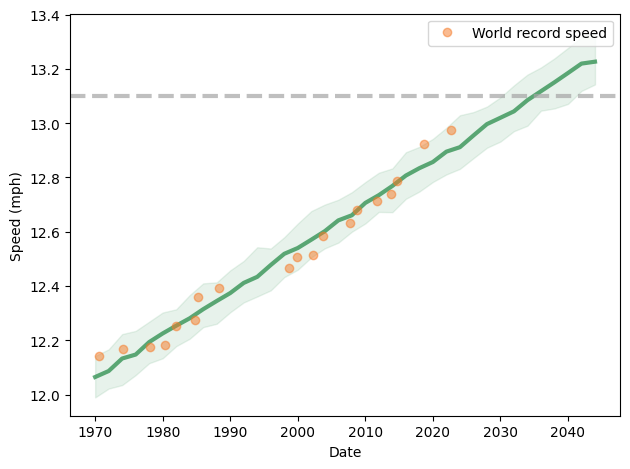

In [139]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high, 
                 color='C2', alpha=0.1)
plt.plot(times, median, color='C2')

plot_speeds(data)

The dashed line shows the two-hour marathon pace, which is 13.1 miles per hour.
Visually we can estimate that the prediction line hits the target pace between 2030 and 2040.

To make this more precise, we can use interpolation to see when the predictions cross the finish line.  SciPy provides `interp1d`, which does linear interpolation by default.

In [140]:
from scipy.interpolate import interp1d

future = np.array([interp1d(high, xs)(13.1),
                   interp1d(median, xs)(13.1),
                   interp1d(low, xs)(13.1)])

In [141]:
dts = pd.to_timedelta(future*365.24, unit='day') + offset
pd.DataFrame(dict(datetime=dts),
             index=['early', 'median', 'late'])

,datetime
early,2030-03-21 01:31:55.356931721
median,2034-12-05 11:05:52.564406591
late,2041-03-20 20:39:02.981876279


The median prediction is 2036, with a 90% credible interval from 2032 to 2043.  So there is about a 5% chance we'll see a two-hour marathon before 2032.

## Summary

This chapter introduces Bayesian regression, which is based on the same model as least squares regression; the difference is that it produces a posterior distribution for the parameters rather than point estimates.

In the first example, we looked at changes in snowfall in Norfolk County, Massachusetts, and concluded that we get more snowfall now than when I was young, contrary to my expectation.

In the second example, we looked at the progression of world record pace for the men's marathon, computed the joint posterior distribution of the regression parameters, and used it to generate predictions for the next 20 years.

These examples have three parameters, so it takes a little longer to compute the likelihood of the data.
With more than three parameters, it becomes impractical to use grid algorithms.  

In the next few chapters, we'll explore other algorithms that reduce the amount of computation we need to do a Bayesian update, which makes it possible to use models with more parameters.

But first, you might want to work on these exercises.

## Exercises


**Exercise:** I am under the impression that it is warmer around here than it used to be.  In this exercise, you can put my conjecture to the test.

We'll use the same dataset we used to model snowfall; it also includes daily low and high temperatures in Norfolk County, Massachusetts during my lifetime.

Here's the data.

In [142]:
df = pd.read_csv('2239075.csv', parse_dates=[2])
df.head(3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, I'll create a column that contains the year part of the dates.

In [143]:
df['YEAR'] = df['DATE'].dt.year

This dataset includes `TMIN` and `TMAX`, which are the daily low and high temperatures in degrees F.
I'll create a new column with the daily midpoint of the low and high temperatures.

In [144]:
df['TMID'] = (df['TMIN'] + df['TMAX']) / 2

Now we can group by year and compute the mean of these daily temperatures.

In [145]:
tmid = df.groupby('YEAR')['TMID'].mean()
len(tmid)

54

Again, I'll drop the first and last years, which are incomplete.

In [146]:
complete = tmid.iloc[1:-1]
len(complete)

52

Here's what the time series looks like.

In [147]:
data = complete.reset_index()
offset = data['YEAR'].mean()


In [148]:
data['x'] = data['YEAR'] - offset
data['y'] = data['TMID']

In [149]:
res = smf.ols('y ~ x', data=data).fit()

In [150]:
res.params, res.resid.std()

(Intercept    49.408046
 x             0.044252
 dtype: float64,
 1.0417057653902058)

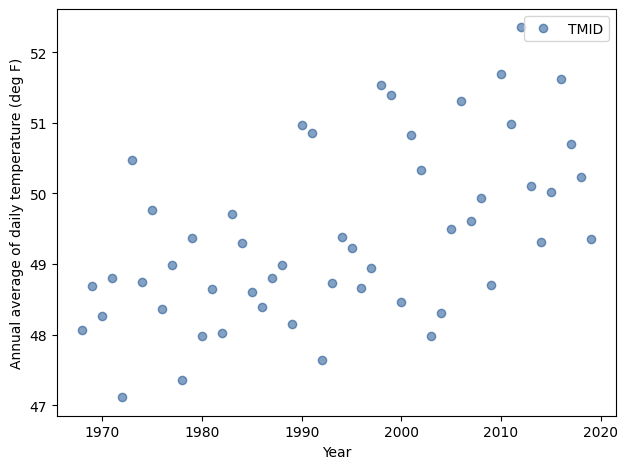

In [151]:
complete.plot(ls='', marker='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Annual average of daily temperature (deg F)')

As we did with the snow data, I'll convert the `Series` to a `DataFrame` to prepare it for regression.

In [152]:
data = complete.reset_index()
data.head()

,YEAR,TMID
0,1968,48.071038
1,1969,48.687671
2,1970,48.258904
3,1971,48.804110
4,1972,47.112022


In [153]:
offset = round(data['YEAR'].mean())
offset

1994

In [154]:
data['x'] = data['YEAR'] - offset
data['x'].mean()

-0.5

In [155]:
data['y'] = data['TMID']
data['y'].std()

1.2389114009625752

Now we can use StatsModels to estimate the parameters.

In [156]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    49.430172
x             0.044252
dtype: float64

And compute the standard deviation of the parameters.

In [157]:
results.resid.std()

1.0417057653902053

According to the least squares regression model, annual average temperature is increasing by about 0.044 degrees F per year.

To quantify the uncertainty of these parameters and generate predictions for the future, we can use Bayesian regression.

1. Use StatsModels to generate point estimates for the regression parameters.

2. Choose priors for `slope`, `intercept`, and `sigma` based on these estimates, and use `make_joint3` to make a joint prior distribution.

3. Compute the likelihood of the data and compute the posterior distribution of the parameters.

4. Extract the posterior distribution of `slope`.  How confident are we that temperature is increasing?

5. Draw a sample of parameters from the posterior distribution and use it to generate predictions up to 2067.

6. Plot the median of the predictions and a 90% credible interval along with the observed data.  

Does the model fit the data well?  How much do we expect annual average temperatures to increase over my (expected) lifetime?

In [158]:
# Solution goes here

res.params, res.resid.std() # priors 

(Intercept    49.408046
 x             0.044252
 dtype: float64,
 1.0417057653902058)

In [159]:
qs = np.linspace(45, 55, 31)
prior_inter = make_uniform(qs, 'Intercept')

qs = np.linspace(-0.5, 0.6, 81)
prior_slope = make_uniform(qs, 'Slope')


qs = np.linspace(0.9, 1.1, 31)
prior_sigma = make_uniform(qs, 'Sigma')


In [160]:
joint3 = make_joint3(prior_slope, prior_inter, prior_sigma)

In [161]:
xs = data['x']
ys = data['y']

In [162]:
prior = joint3.copy()

likelihood = prior.copy()

for slope, inter, sigma in prior.index:
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm(0, sigma).pdf(resid)
    likelihood[slope, inter, sigma] = densities.prod()

In [163]:
# Solution goes here
posterior = prior * likelihood

In [164]:
posterior.normalize()

1.0158110716958079e-36

In [165]:
posterior.index

MultiIndex([(-0.5, 45.0,                0.9),
            (-0.5, 45.0, 0.9066666666666667),
            (-0.5, 45.0, 0.9133333333333333),
            (-0.5, 45.0,               0.92),
            (-0.5, 45.0, 0.9266666666666667),
            (-0.5, 45.0, 0.9333333333333333),
            (-0.5, 45.0, 0.9400000000000001),
            (-0.5, 45.0, 0.9466666666666667),
            (-0.5, 45.0, 0.9533333333333334),
            (-0.5, 45.0, 0.9600000000000001),
            ...
            ( 0.6, 55.0,               1.04),
            ( 0.6, 55.0, 1.0466666666666669),
            ( 0.6, 55.0, 1.0533333333333335),
            ( 0.6, 55.0,               1.06),
            ( 0.6, 55.0, 1.0666666666666667),
            ( 0.6, 55.0, 1.0733333333333335),
            ( 0.6, 55.0,               1.08),
            ( 0.6, 55.0, 1.0866666666666667),
            ( 0.6, 55.0, 1.0933333333333335),
            ( 0.6, 55.0,                1.1)],
           names=['Slope', 'Intercept', 'Sigma'], length=77841)

In [166]:
posterior_slope = posterior.marginal(0)
posterior_intercept = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

In [167]:
summarize(posterior_slope)

0.044 [0.03625 0.06375]


In [168]:
1 - posterior_slope.prob_le(0) # 99 % confident temp is rising 

0.9999987658139983

In [169]:
data

,YEAR,TMID,x,y
0,1968,48.071038,-26,48.071038
1,1969,48.687671,-25,48.687671
2,1970,48.258904,-24,48.258904
3,1971,48.804110,-23,48.804110
4,1972,47.112022,-22,47.112022
5,1973,50.479452,-21,50.479452
6,1974,48.741096,-20,48.741096
7,1975,49.758904,-19,49.758904
8,1976,48.360656,-18,48.360656
9,1977,48.989041,-17,48.989041


In [170]:
yrs = np.arange(data['YEAR'].min(), 2068, 1)
yrs

xs_pred = yrs - offset

In [175]:
sample = posterior.choice(1001)
pred = np.empty((len(sample), len(xs_pred)))

for i, (slope, inter, sigma) in enumerate(sample):
    epsilon = norm(0, sigma).rvs(len(xs_pred))
    pred[i] = slope * xs_pred + inter + epsilon

In [176]:
low, median, high = np.quantile(pred, [0.05, 0.5, 0.95], axis = 0)

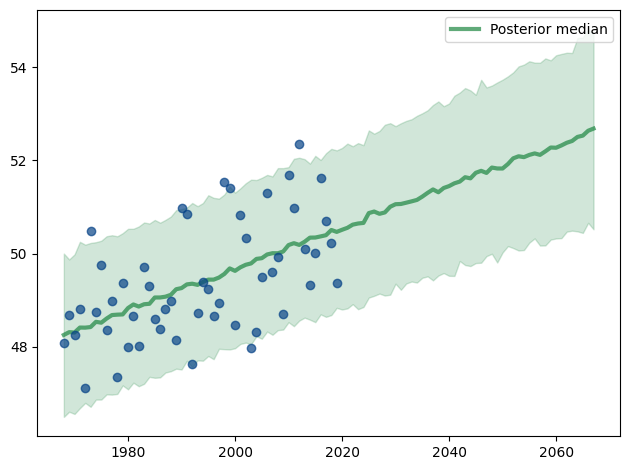

In [177]:
plt.fill_between(yrs, low, high, color='C2', alpha=0.2)
plt.plot(yrs, median, color='C2', label='Posterior median')
plt.plot(data['YEAR'], data['TMID'], 'o')
decorate()

In [178]:
len(data)

52

In [179]:
6 / 52 # conf interval does not cover 90 % wtf

0.11538461538461539